In [12]:
from src.data import gedi_pipeline

import seaborn as sns
from fastai.tabular.all import save_pickle, load_pickle
import matplotlib.pyplot as plt
palette = sns.color_palette("Set2")

sns.set_theme()
import ee
import geopandas as gpd
from src.data import gedi_pipeline
from src.data.ee import lcms_import
from src.processing.regen import regen_analysis
from src.data.ee import ee_utils
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.data import fire_perimeters
from src.data import gedi_raster_matching
from src.data import raster
import rasterio as rio
from src.data import shape_processor
import matplotlib.pyplot as plt
import pandas as pd
from src.constants import DATA_PATH, USER_PATH
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
from fastai.tabular.all import save_pickle
from src.visualization.dists import plot_pdf
from src.data import gedi_pipeline
import seaborn as sns
from fastai.tabular.all import load_pickle, save_pickle, patch
from src.constants import DATA_PATH
from src.data import gedi_raster_matching
from src.processing.rf import split_data
from fastai.tabular.all import *
from sklearn.metrics import *
from src.utils.logging_util import get_logger
from sklearn.ensemble import RandomForestRegressor
from src.processing.rf import train
from sklearn.inspection import PartialDependenceDisplay
from fastbook import *

sns.set_theme()

import importlib
importlib.reload(regen_analysis)
importlib.reload(gedi_pipeline)
importlib.reload(ee_utils)
importlib.reload(gedi_raster_matching)
importlib.reload(raster)
importlib.reload(fire_perimeters)

2023-10-28 18:39:17,365 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-10-28 18:39:17,366 DEBUG: Logger /home/jk871/fire-regen/src/data/ee/ee_utils.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-10-28 18:39:17,367 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_raster_matching.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-10-28 18:39:17,369 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.fire_perimeters' from '/home/jk871/fire-regen/src/data/fire_perimeters.py'>

In [3]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)


def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def rf(xs, y, n_estimators=100, max_samples=0.85,
       max_features=0.5, min_samples_leaf=30, max_leaf_nodes=None, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True, max_leaf_nodes=max_leaf_nodes).fit(xs, y)



In [5]:
def train_rf(df_in, columns_to_use, dep_var, log=False):
    df = df_in[columns_to_use].dropna()
    if log:
        df = df[df[dep_var] != 0]
        df[dep_var] = np.log(df[dep_var])
    df = df.dropna()
    procs = [Categorify, FillMissing]
    cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
    to = TabularPandas(df, procs, cat, cont, y_names=dep_var)
    xs, y = to.train.xs, to.train.y
    m = rf(xs, y)
    rmse_train = train.m_rmse(m, xs, y)
    r2_train = train.m_r2(m, xs, y)
    print(rmse_train, r2_train)
    return m, xs, y

In [2]:
gedi_burned, gedi_unburned = gedi_pipeline.load_stage_11()

In [4]:
gedi_burned.columns

Index(['shot_number', 'beam_type', 'absolute_time', 'longitude', 'latitude',
       'elevation_difference_tdx', 'agbd', 'agbd_se', 'fhd_normal', 'pai',
       'pai_z', 'pavd_z', 'rh_98', 'rh_70', 'rh_50', 'rh_25', 'cover',
       'cover_z', 'sensitivity_a0', 'solar_elevation', 'gridded_pft_class',
       'geometry', 'gedi_year', 'gedi_month', 'severity', 'burn_year',
       'burn_count', 'time_since_burn', 'aspect_2x2', 'aspect_mean',
       'aspect_std', 'aspect_median', 'elevation_2x2', 'elevation_mean',
       'elevation_std', 'elevation_median', 'slope_2x2', 'slope_mean',
       'slope_std', 'slope_median', 'soil_2x2', 'soil_mean', 'soil_std',
       'soil_median', 'SR_B1_2x2', 'SR_B1_mean', 'SR_B1_std', 'SR_B1_median',
       'SR_B2_2x2', 'SR_B2_mean', 'SR_B2_std', 'SR_B2_median', 'SR_B3_2x2',
       'SR_B3_mean', 'SR_B3_std', 'SR_B3_median', 'SR_B4_2x2', 'SR_B4_mean',
       'SR_B4_std', 'SR_B4_median', 'SR_B5_2x2', 'SR_B5_mean', 'SR_B5_std',
       'SR_B5_median', 'SR_B6_2x2', '

# Predicting RH_98 on high severity burns

In [26]:
df_in = gedi_burned[gedi_burned.severity == 4]

## Predicting without any Landsat metrics

In [9]:
columns_to_use = ['rh_98',
                  'beam_type',
                  'elevation_difference_tdx',
                  'solar_elevation',
                  'sensitivity_a0',
                  'gridded_pft_class',
                  'burn_year',
                  'burn_count',
                  'time_since_burn',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median',
                  'dw_land_cover_median']
m, xs, y = train_rf(df_in, columns_to_use, "rh_98", log=False)

5.88647 0.43345295874698164


In [1]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

NameError: name 'rf_feat_importance' is not defined

                        cols       imp
1   elevation_difference_tdx  0.238195
10              slope_median  0.208008
3             sensitivity_a0  0.114821
4          gridded_pft_class  0.087910
5                  burn_year  0.080616
9           elevation_median  0.077359
12      dw_land_cover_median  0.064184
7            time_since_burn  0.044132
2            solar_elevation  0.033888
8              aspect_median  0.026060


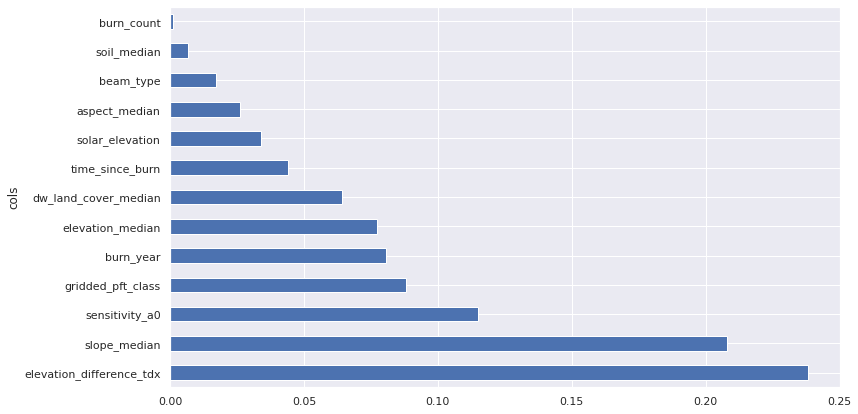

In [13]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

In [ ]:
cluster_columns(xs)

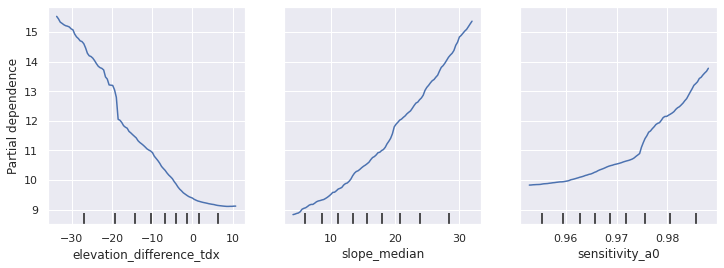

In [14]:
fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['elevation_difference_tdx', 'slope_median', 'sensitivity_a0'], ax=ax)

# Predicting RH_98 without elevation_difference_tdx

6.357108 0.33923764431363124
                   cols       imp
5          slope_median  0.369227
4      elevation_median  0.177833
0             burn_year  0.143061
7  dw_land_cover_median  0.127099
2       time_since_burn  0.081696
3         aspect_median  0.070933
6           soil_median  0.023079
1            burn_count  0.007073


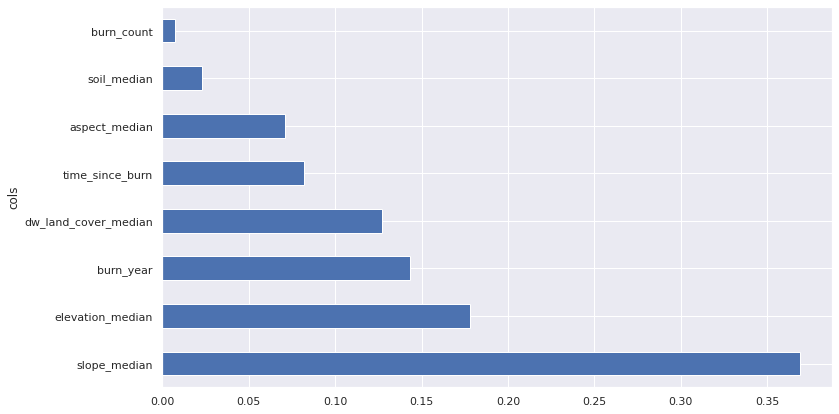

In [36]:
columns_to_use = ['rh_98',
                  #'beam_type',
                  #'solar_elevation',
                  #'sensitivity_a0',
                  #'gridded_pft_class',
                  'burn_year',
                  'burn_count',
                  'time_since_burn',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median',
                  'dw_land_cover_median']
m, xs, y = train_rf(df_in, columns_to_use, "rh_98", log=False)
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

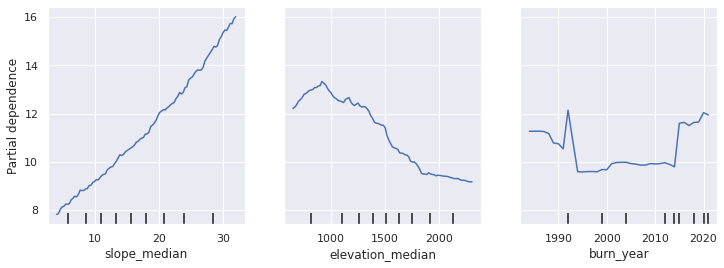

In [37]:
fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['slope_median', 'elevation_median', 'burn_year'], ax=ax)

# Predicting RH_98 on low severity burns

### Predicting without elevation_difference_tdx

In [38]:
df_in = gedi_burned[(gedi_burned.severity == 2)]

8.748549 0.4853471982279415
                    cols       imp
11  dw_land_cover_median  0.312778
8       elevation_median  0.129387
4              burn_year  0.114155
2         sensitivity_a0  0.111789
9           slope_median  0.084269
6        time_since_burn  0.071558
3      gridded_pft_class  0.051717
1        solar_elevation  0.040559
7          aspect_median  0.034219
10           soil_median  0.020751


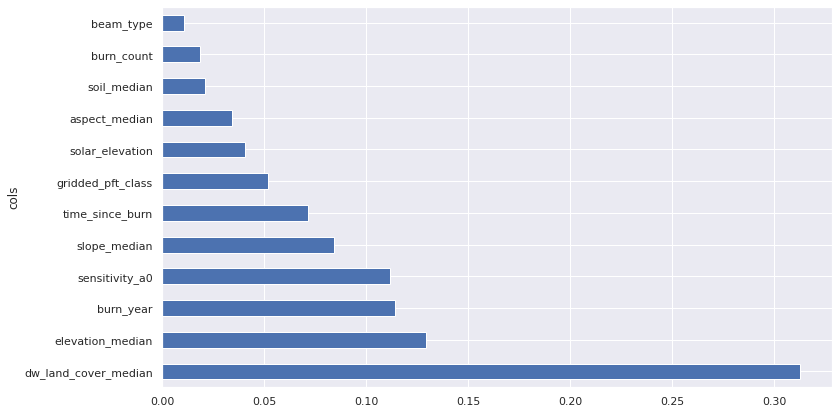

In [39]:
columns_to_use = ['rh_98',
                  'beam_type',
                  'solar_elevation',
                  'sensitivity_a0',
                  'gridded_pft_class',
                  'burn_year',
                  'burn_count',
                  'time_since_burn',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median',
                  'dw_land_cover_median']
m, xs, y = train_rf(df_in, columns_to_use, "rh_98", log=False)
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

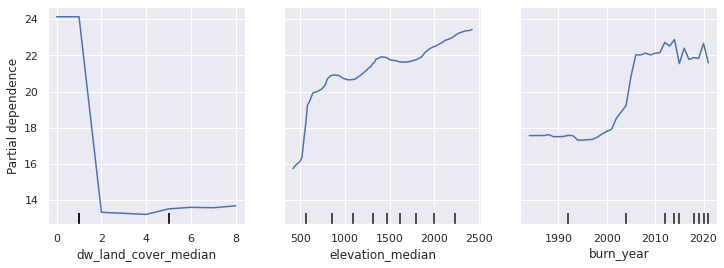

In [40]:
fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['dw_land_cover_median', 'elevation_median', 'burn_year'], ax=ax)

In [21]:
columns_to_use = ['rh_98',
                  'beam_type',
                  'elevation_difference_tdx',
                  'solar_elevation',
                  'sensitivity_a0',
                  'gridded_pft_class',
                  'burn_year',
                  'burn_count',
                  'time_since_burn',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median',
                  'dw_land_cover_median']
m, xs, y = train_rf(df_in, columns_to_use, "rh_98", log=False)


8.529843 0.4937006368713265


                        cols       imp
1   elevation_difference_tdx  0.485284
5                  burn_year  0.103499
9           elevation_median  0.096556
3             sensitivity_a0  0.089532
10              slope_median  0.073387
7            time_since_burn  0.049072
2            solar_elevation  0.024618
8              aspect_median  0.021839
4          gridded_pft_class  0.019946
0                  beam_type  0.019768


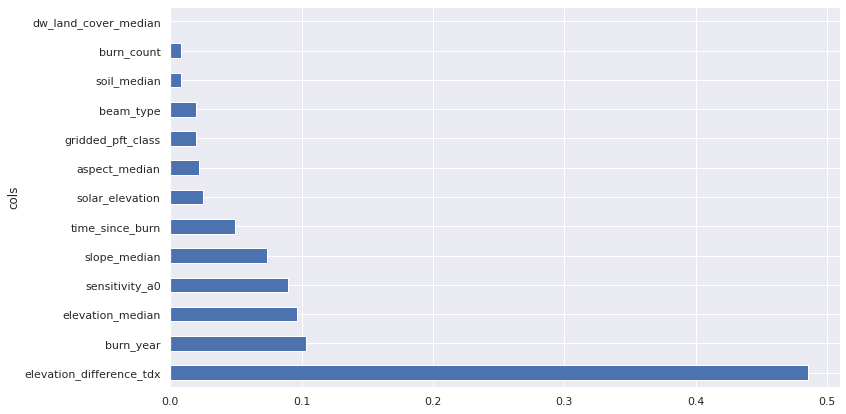

In [22]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])
print(fi[:10])

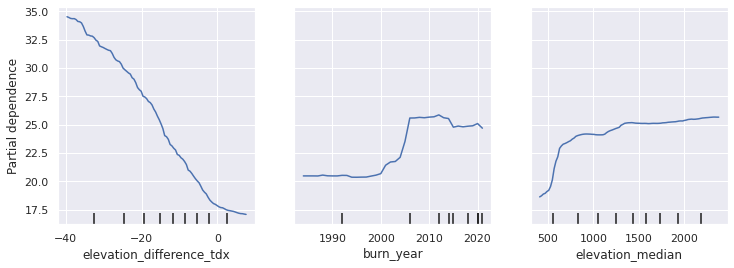

In [23]:
fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['elevation_difference_tdx', 'burn_year', 'elevation_median'], ax=ax)

In [24]:
cluster_columns(xs)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


ValueError: Distance matrix 'X' must be symmetric.

## Predicting without any Landsat metrics

In [16]:
columns_to_use = ['rh_98',
                  'beam_type',
                  'elevation_difference_tdx',
                  'solar_elevation',
                  'sensitivity_a0',
                  'gridded_pft_class',
                  'burn_year',
                  'burn_count',
                  'time_since_burn',
                  'aspect_median',
                  'elevation_median',
                  'slope_median',
                  'soil_median',
                  'dw_land_cover_median']
m, xs, y = train_rf(df_in, columns_to_use, "rh_98", log=False)

8.077101 0.561314408470682


In [36]:
dep_var = 'agbd'

In [37]:
df = gedi_burned[columns_to_use]

In [38]:
df = df[df.agbd != 0]
df[dep_var] = np.log(df[dep_var])

In [39]:
df['beam_type'] = df['beam_type'].astype('category')

In [40]:
df["beam_type"] = df['beam_type'].cat.set_categories(["full", "coverage"], ordered=True)

In [20]:
df.dtypes

agbd                         float64
beam_type                   category
elevation_difference_tdx     float64
solar_elevation              float64
sensitivity_a0               float64
gridded_pft_class              int64
severity                     float64
burn_year                    float64
burn_count                   float64
time_since_burn              float64
aspect_median                float32
elevation_median             float32
slope_median                 float32
soil_median                  float32
dw_land_cover_median         float64
dtype: object

In [57]:
procs = [Categorify, FillMissing]

In [58]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [59]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(c):


In [60]:
xs, y = to.train.xs, to.train.y

In [61]:
def rf(xs, y, n_estimators=100, max_samples=0.85,
       max_features=0.5, min_samples_leaf=30, max_leaf_nodes=None, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True, max_leaf_nodes=max_leaf_nodes).fit(xs, y)



In [62]:
m = rf(xs, y)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated

In [63]:
rmse_train = train.m_rmse(m, xs, y)
r2_train = train.m_r2(m, xs, y)
print(rmse_train, r2_train)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated

0.66935 0.6787960160997767


/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [64]:

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [65]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
6,gridded_pft_class,0.247992
13,slope_median,0.153896
7,severity,0.147320
3,elevation_difference_tdx,0.141011
15,dw_land_cover_median,0.137020
8,burn_year,0.038090
12,elevation_median,0.037622
5,sensitivity_a0,0.034267
10,time_since_burn,0.022262
4,solar_elevation,0.011431


In [52]:
df.drop(columns="beam_type").corr()

,agbd,elevation_difference_tdx,solar_elevation,sensitivity_a0,gridded_pft_class,severity,burn_year,burn_count,time_since_burn,aspect_median,elevation_median,slope_median,soil_median,dw_land_cover_median
agbd,1.000000,-0.335223,-0.007862,0.274509,-0.450956,-0.352000,0.109745,-0.007976,-0.105720,0.028303,-0.105298,0.350021,-0.047576,-0.399689
elevation_difference_tdx,-0.335223,1.000000,0.008370,-0.086022,0.179863,0.062372,-0.259798,0.045411,0.255945,0.032183,0.016545,-0.137617,0.068279,0.130741
solar_elevation,-0.007862,0.008370,1.000000,-0.038046,-0.001351,0.014836,-0.033198,0.010794,0.021434,0.005355,-0.029714,0.008341,-0.021762,-0.017206
sensitivity_a0,0.274509,-0.086022,-0.038046,1.000000,-0.263091,-0.048538,-0.050156,0.005963,0.042505,0.027545,-0.093207,0.147954,-0.037504,-0.158031
gridded_pft_class,-0.450956,0.179863,-0.001351,-0.263091,1.000000,0.090087,-0.124627,-0.021968,0.113195,-0.042150,0.253949,-0.105648,0.128380,0.261101
severity,-0.352000,0.062372,0.014836,-0.048538,0.090087,1.000000,-0.092604,-0.066340,0.093971,-0.021946,0.048835,-0.025370,-0.068949,0.194600
burn_year,0.109745,-0.259798,-0.033198,-0.050156,-0.124627,-0.092604,1.000000,0.154418,-0.994163,-0.016154,0.143376,0.114770,-0.095189,0.155570
burn_count,-0.007976,0.045411,0.010794,0.005963,-0.021968,-0.066340,0.154418,1.000000,-0.154311,0.005033,-0.103858,0.099481,-0.015385,0.043411
time_since_burn,-0.105720,0.255945,0.021434,0.042505,0.113195,0.093971,-0.994163,-0.154311,1.000000,0.016434,-0.137439,-0.114830,0.096552,-0.154418
aspect_median,0.028303,0.032183,0.005355,0.027545,-0.042150,-0.021946,-0.016154,0.005033,0.016434,1.000000,-0.025535,0.042010,0.002279,-0.055550


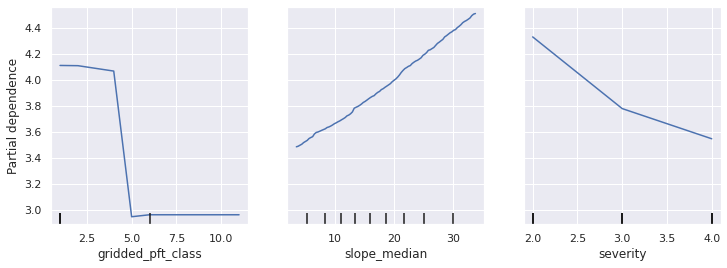

In [66]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['gridded_pft_class','slope_median', 'severity'], ax=ax)
#plot_partial_dependence(m, valid_xs_final, ['pft_class','slope'],
#                        grid_resolution=20, ax=ax)

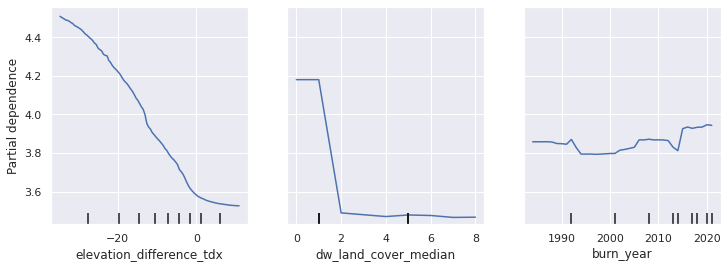

In [68]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['elevation_difference_tdx','dw_land_cover_median', 'burn_year'], ax=ax)
#plot_partial_dependence(m, valid_xs_final, ['pft_class','slope'],
#                        grid_resolution=20, ax=ax)

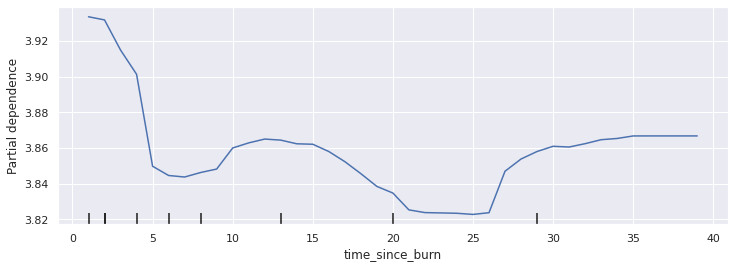

In [69]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, xs, ['time_since_burn'], ax=ax)
#plot_partial_dependence(m, valid_xs_final, ['pft_class','slope'],
#                        grid_resolution=20, ax=ax)